# Calibrating the MATILDA framework

In this notebook we will

1. ... set up a glacio-hydrological model with all the data we have collected,

2. ... run the model for the calibration period with default parameters and check the results,

3. ... use a statistical parameter optimization routine to calibrate the model,

4. ... and store the calibrated parameter set for the scenario runs in the next notebook.


We will use the glacio-hydrological modeling library [MATILDA] (https://github.com/cryotools/matilda), which has been developed for use in this workflow. It is based on the widely used [HBV hydrological model](https://www.cabdirect.org/cabdirect/abstract/19961904773), extended by a simple temperature-index melt model based roughly on the code of [Seguinot (2019)](https://zenodo.org/record/3467639). Glacier evolution over time is modeled using the &Delta;*h* approach following [Seibert et. al. (2018)](https://doi.org/10.5194/hess-22-2211-2018).

Let's start by importing some helper functions to work with `yaml` and `pickle` files and read required data from the config file.

In [1]:
from tools.helpers import update_yaml, read_yaml, write_yaml
import configparser
import ast

# read local config.ini file
config = configparser.ConfigParser()
config.read('config.ini')

# get output dir and date range from config.ini
dir_input = config['FILE_SETTINGS']['DIR_INPUT']
dir_output = config['FILE_SETTINGS']['DIR_OUTPUT']
date_range = ast.literal_eval(config['CONFIG']['DATE_RANGE'])

print('MATILDA will be calibrated on the period ' + date_range[0] + ' to ' + date_range[1])

MATILDA will be calibrated on the period 1998-01-01 to 2020-12-31


The model requires a minimum setup period of one year. By default, the first two years are considered setup. We derive the respective dates from  the defined time period accordingly.

In [2]:
import pandas as pd

length_of_setup_period = 2

sim_start = pd.to_datetime(date_range[0]) + pd.DateOffset(years = length_of_setup_period)
set_up_end = sim_start - pd.DateOffset(days = 1)

dates = {'set_up_start': date_range[0],
         'set_up_end': str(set_up_end).split(' ')[0],        # remove hh:mm:ss
         'sim_start': str(sim_start).split(' ')[0],          # remove hh:mm:ss
         'sim_end': date_range[1]}

for key in dates.keys(): print(key + ': ' + dates[key])

set_up_start: 1998-01-01
set_up_end: 1999-12-31
sim_start: 2000-01-01
sim_end: 2020-12-31


Many MATILDA parameters have been calculated in previous notebooks and stored in `settings.yaml`. We can easily add the modeling periods using a helper function. The calculated glacier profile from Notebook 1 can be imported as a `pandas DataFrame` and added to the settings dictionary as well.

Finally, we will also add some optional settings that control the aggregation frequency of the outputs, the choice of graphical outputs, and more.

In [3]:
update_yaml(dir_output + 'settings.yml', dates)

remaining_settings = {"freq": "M",               # aggregation level of model outputs (D, M, Y)
                      "warn": False,             # show warnings of subpackages?
                      "plot_type": "all",        # interactive and/or non-interactive plots ('print', 'interactive', 'all')
                      "elev_rescaling": True}    # treat mean glacier elevation as constant or change with glacier evolution

update_yaml(dir_output + 'settings.yml', remaining_settings)

settings = read_yaml(dir_output + 'settings.yml')
glacier_profile = pd.read_csv(dir_output + 'glacier_profile.csv')
settings['glacier_profile'] = glacier_profile

print('MATILDA settings:\n\n')
for key in settings.keys(): print(key + ': ' + str(settings[key]))

MATILDA settings:


area_cat: 295.67484249904464
area_glac: 31.829413146585885
ele_cat: 3293.491688025922
ele_dat: 3335.668840874115
ele_glac: 4001.8798828125
elev_rescaling: True
freq: M
lat: 42.18280043250193
plot_type: all
set_up_end: 1999-12-31
set_up_start: 1998-01-01
sim_end: 2020-12-31
sim_start: 2000-01-01
warn: False
glacier_profile:      Elevation      Area          WE  EleZone
0       1970.0  0.000000      0.0000     1900
1       2000.0  0.000000      0.0000     2000
2       2100.0  0.000000      0.0000     2100
3       2200.0  0.000000      0.0000     2200
4       2300.0  0.000000      0.0000     2300
..         ...       ...         ...      ...
156     4730.0  0.000023  20721.3700     4700
157     4740.0  0.000013  14450.2180     4700
158     4750.0  0.000006  10551.4730     4700
159     4760.0  0.000000      0.0000     4700
160     4780.0  0.000002   6084.7456     4700

[161 rows x 4 columns]


## Run MATILDA with default parameters

We will force MATILDA with the pre-processed ERA5-Land data from Notebook 2. Although MATILDA can run without calibration on observations, the results would have extreme uncertainties. Therefore, we recommend to use at least runoff observations for your selected point to evaluate the simulations against. Here, we load runoff observations for your example catchment from 1982 to 2020 (with gaps).

In [4]:
era5 = pd.read_csv(dir_output + 'ERA5L.csv', usecols=['dt', 'temp', 'prec'])
era5.columns = ['TIMESTAMP','T2', 'RRR']

# remove HH:MM:SS from 'TIMESTAMP' column
era5['TIMESTAMP'] = pd.to_datetime(era5['TIMESTAMP'])
era5['TIMESTAMP'] = era5['TIMESTAMP'].dt.date

obs = pd.read_csv(dir_input + 'obs_runoff_example.csv')

print(obs)

             Date  Qobs
0      01/01/1982  1.31
1      01/02/1982  1.19
2      01/03/1982  1.31
3      01/04/1982  1.31
4      01/05/1982  1.19
...           ...   ...
14240  12/27/2020  3.25
14241  12/28/2020  3.23
14242  12/29/2020  3.08
14243  12/30/2020  2.93
14244  12/31/2020  2.93

[14245 rows x 2 columns]


First, we run MATILDA with default parameters.

---
MATILDA framework
Reading parameters for MATILDA simulation
Parameter set:
set_up_start     1998-01-01
set_up_end       1999-12-31
sim_start        2000-01-01
sim_end          2020-12-31
freq                      M
freq_long           Monthly
lat                 42.1828
area_cat         295.674842
area_glac         31.829413
ele_dat         3335.668841
ele_cat         3293.491688
ele_glac        4001.879883
ele_non_glac    3208.034151
hydro_year               10
soi                    None
warn                  False
pfilter                   0
lr_temp              -0.006
lr_prec                   0
TT_snow                   0
TT_rain                   2
TT_diff                   2
CFMAX_snow              2.5
CFMAX_ice                 5
CFMAX_rel                 2
BETA                    1.0
CET                    0.15
FC                      250
K0                    0.055
K1                    0.055
K2                     0.04
LP                      0.7
MAXBAS                  3

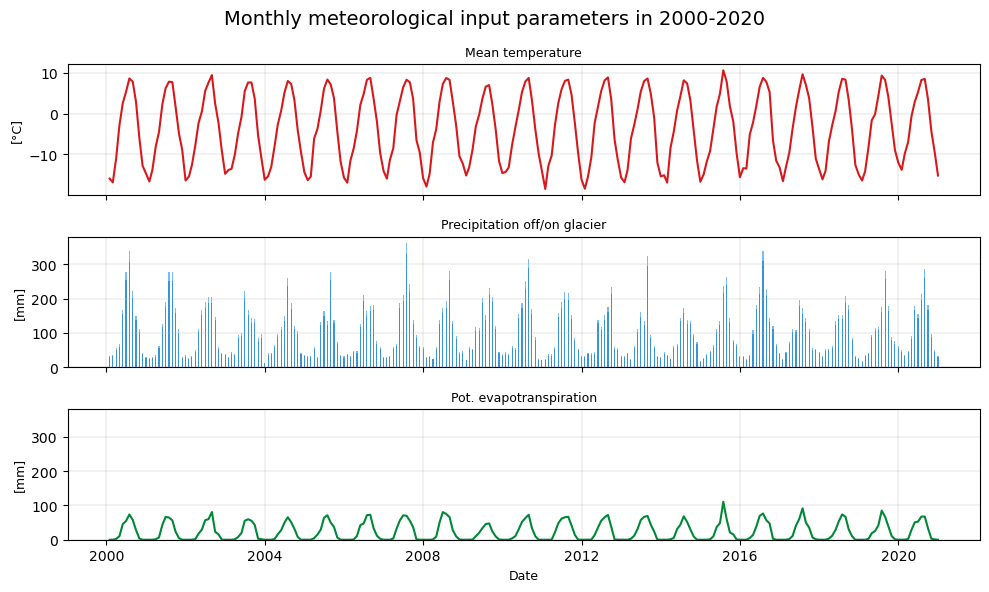

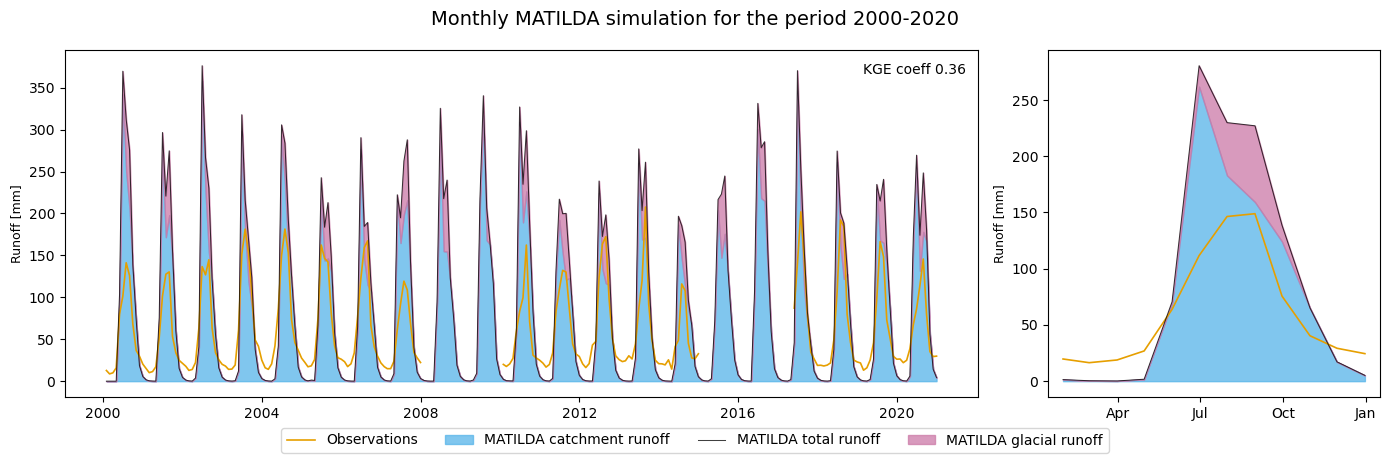

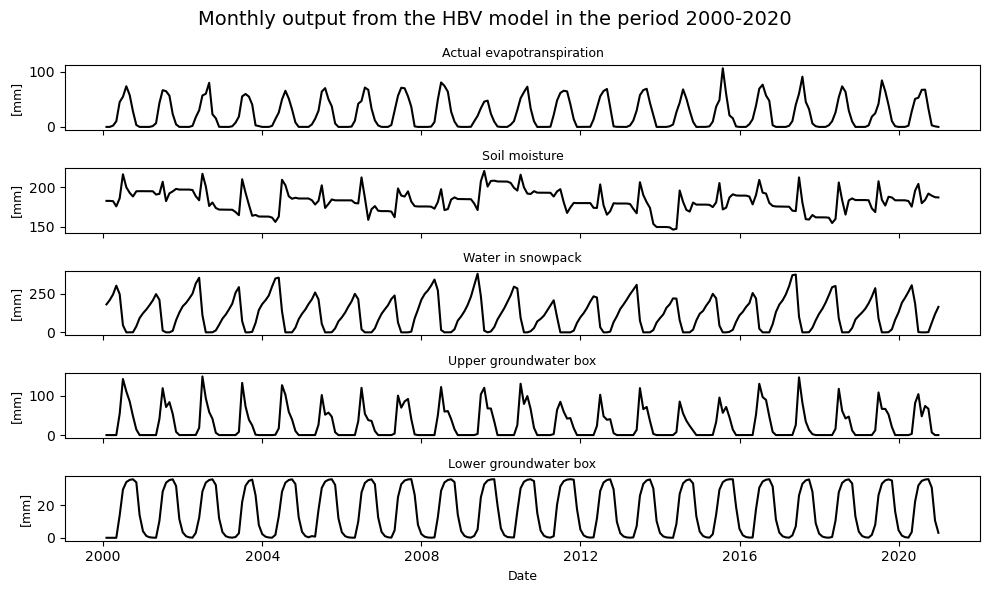

In [5]:
from matilda.core import matilda_simulation

output_matilda = matilda_simulation(era5, obs, **settings)

The result is obviously far from reality and largely overestimates runoff. Therefore, the model needs calibration.

## Calibrate MATILDA

To adjust all model parameters to the catchment characteristics, we will perform an automated calibration using the [Statistical Parameter Optimization Tool for Python](https://doi.org/10.1371/journal.pone.0145180). Since large uncertainties in the input data (especially precipitation) can lead to an overestimation of melt when the model is calibrated to the hydrograph only, we will additionally include glacier mass balance data for a multi-objective calibration.

**Note:** Statistical parameter optimization (SPOT) algorithms require a large number of model runs, especially for large parameter sets. Both *mybinder.org* and *Google Colab* offer a maximum of two cores per user. One MATILDA run for 20 years takes roughly 3s on one core. Therefore, large optimization runs in an online environment will be slow and may require you to leave the respective browser tab in the foreground for hours. To speed things up, you can either...

... run this notebook locally on a computer with more cores (ideally a high performance cluster) or ...

... reduce the number of calibration parameters using the global sensitivity. We will return to this topic later in this notebook.

Here we will demonstrate the use of the SPOT functions and then continue with a parameter set from a large HPC optimization run. If you need assistance to implement the routine on your HPC consult the [SPOTPY documentation](https://spotpy.readthedocs.io/en/latest/Advanced_hints/#mpi-parallel-computing) and contact us if you run into problems.

### Add glacier mass balance data

In addition to runoff we will use glacier mass balance as second calibration variable. [Shean et. al. 2020 ](https://doi.org/10.3389/feart.2019.00363) calculated robust geodetic mass balances for all glaciers in High Mountain Asia from 2000 to 2018. For this example (and all other catchments in HMA), we can use their data set so derive a target average annual mass balance in the calibration period. If your catchment is located outside HMA, you need to consult other sources.

We pick all individual mass balances that match the glacier IDs in our catchment and calculate the mean. In addition, we use the uncertainty measures listed in the dataset to derive an uncertainty range.

In [6]:
import pandas as pd

mass_balances = pd.read_csv(dir_input + '/hma_mb_20190215_0815_rmse.csv', usecols=['RGIId', 'mb_mwea', 'mb_mwea_sigma'])
ids = pd.read_csv(dir_output + '/RGI/Glaciers_in_catchment.csv')

merged = pd.merge(mass_balances, ids, on='RGIId')
mean_mb = round(merged['mb_mwea'].mean() * 1000, 3)   # Mean catchment MB in mm w.e.
mean_sigma = round(merged['mb_mwea_sigma'].mean() * abs(mean_mb), 3)  # Mean uncertainty of catchment MB in mm w.e.

target_mb = [mean_mb - mean_sigma, mean_mb + mean_sigma]

print('Target glacier mass balance for calibration: ' + str(mean_mb) + ' +-' + str(mean_sigma) + 'mm w.e.')

Target glacier mass balance for calibration: -155.474 +-50.3mm w.e.


The MATILDA framework provides an interface to [SPOTPY](https://github.com/thouska/spotpy/). Here we will use the `psample()` function to run MATILDA with the same settings as before. To do this, we will remove redundant `settings` and add some new ones specific to the function. Be sure to choose the number of repetitions carefully.

In [7]:
from tools.helpers import drop_keys

psample_settings = drop_keys(settings, ['warn', 'plots', 'plot_type'])

additional_settings = {'rep': 10,                            # Number of model runs. For advice check the documentation of the algorithms.
                       'glacier_only': False,                 # True when calibrating a entirely glacierized catchment
                       'obj_dir': 'maximize',                 # should your objective funtion be maximized (e.g. NSE) or minimized (e.g. RMSE)
                       'target_mb': -156,                     # Average annual glacier mass balance to target at
                       'dbformat': None,                      # Write the results to a file ('csv', 'hdf5', 'ram', 'sql')
                       'output': None,                        # Choose where to store the files
                       'algorithm': 'lhs',                    # Choose algorithm (for parallelization: mc, lhs, fast, rope, sceua or demcz)
                       'dbname': 'era5_matilda_example',      # Choose name
                       
                       'parallel': False,                     # Distribute the calculation on multiple cores or not
                      # 'cores': 20                           # Set number of cores when running parallel
                      }
psample_settings.update(additional_settings)

print('Settings for calibration runs:\n\n')
for key in psample_settings.keys(): print(key + ': ' + str(psample_settings[key]))

Settings for calibration runs:


area_cat: 295.67484249904464
area_glac: 31.829413146585885
ele_cat: 3293.491688025922
ele_dat: 3335.668840874115
ele_glac: 4001.8798828125
elev_rescaling: True
freq: M
lat: 42.18280043250193
set_up_end: 1999-12-31
set_up_start: 1998-01-01
sim_end: 2020-12-31
sim_start: 2000-01-01
glacier_profile:      Elevation      Area          WE  EleZone  norm_elevation   delta_h
0       1970.0  0.000000      0.0000     1900        1.000000  1.003442
1       2000.0  0.000000      0.0000     2000        0.989324  0.945813
2       2100.0  0.000000      0.0000     2100        0.953737  0.774793
3       2200.0  0.000000      0.0000     2200        0.918149  0.632696
4       2300.0  0.000000      0.0000     2300        0.882562  0.515361
..         ...       ...         ...      ...             ...       ...
156     4730.0  0.000023  20721.3700     4700        0.017794 -0.000265
157     4740.0  0.000013  14450.2180     4700        0.014235 -0.000692
158     4750.0  0.000

With these settings we can start the `psample()` to run our model with various parameter combinations. The default parameter boundaries can be found in the MATILDA [parameter documentation](https://github.com/cryotools/matilda/blob/master/Parameters). If you want to narrow down the parameter space you can do that using the following syntax. Here, we define custom ranges for the temperature lapse rate and the precipitation correction factor.

In [8]:
from matilda.mspot_glacier import psample

lim_dict = {'lr_temp_lo': -0.007, 'lr_temp_up': -0.005, 'PCORR_lo': 0.5, 'PCORR_up': 1.5}

best_summary = psample(df=era5, obs=obs, **psample_settings, **lim_dict)

Initializing the  Latin Hypercube Sampling (LHS)  with  10  repetitions
The objective function will be maximized
Starting the LHS algotrithm with 10 repetitions...
Creating LatinHyperCube Matrix
1 of 10, maximal objective function=0.0966527, time remaining: 00:00:13
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
2 of 10, maximal objective function=0.200707, time remaining: 00:00:14
3 of 10, maximal objective function=0.200707, time remaining: 00:00:13
4 of 10, maximal objective function=0.200707, time remaining: 00:00:11
5 of 10, maximal objective function=0.200707, time remaining: 00:00:10
6 of 10, maximal objective function=0.200707, time remaining: 00:00:07
7 of 10, maximal objective function=0.200707, time remaining: 00:00:05
8 of 10, maximal objective function=0.545193, time remaining: 00:00:02
9 of 10, maximal objective function=0.545193, time remaining: 00:00:00
10 of 10, maximal objective function=0.545193, time remaining: 23:59:57

*** Final SPOTPY su

## Run MATILDA with calibrated parameters

The following parameter set was computed using an updated version of the Differential Evolution Markov Chain (DE-MCz) algorithm with 55k iterations on an HPC cluster. The parameters were optimized for runoff using the [Kling-Gupta model efficiency coefficient](https://doi.org/10.1016/j.jhydrol.2012.01.011) and the results were filtered to match the target mass balance range.
<a id="param"></a>

In [9]:
param = {'lr_temp': -0.006472598,
         'lr_prec': 0.00010296448,
         'BETA': 4.625306,
         'CET': 0.2875196,
         'FC': 364.81818,
         'K0': 0.28723368,
         'K1': 0.015692418,
         'K2': 0.004580627,
         'LP': 0.587188,
         'MAXBAS': 6.730105,
         'PERC': 1.1140852,
         'UZL': 198.82584,
         'PCORR': 0.74768984,
         'TT_snow': -1.3534238,
         'TT_diff': 0.70977557,
         'CFMAX_ice': 2.782649,
         'CFMAX_rel': 1.2481626,
         'SFCF': 0.879982,
         'CWH': 0.0020890352,
         'AG': 0.8640329,
         'RFS': 0.21825151}

print('Calibrated parameter set:\n\n')
for key in param.keys(): print(key + ': ' + str(param[key]))

Calibrated parameter set:


lr_temp: -0.006472598
lr_prec: 0.00010296448
BETA: 4.625306
CET: 0.2875196
FC: 364.81818
K0: 0.28723368
K1: 0.015692418
K2: 0.004580627
LP: 0.587188
MAXBAS: 6.730105
PERC: 1.1140852
UZL: 198.82584
PCORR: 0.74768984
TT_snow: -1.3534238
TT_diff: 0.70977557
CFMAX_ice: 2.782649
CFMAX_rel: 1.2481626
SFCF: 0.879982
CWH: 0.0020890352
AG: 0.8640329
RFS: 0.21825151


---
MATILDA framework
Reading parameters for MATILDA simulation
Parameter set:
set_up_start     1998-01-01
set_up_end       1999-12-31
sim_start        2000-01-01
sim_end          2020-12-31
freq                      M
freq_long           Monthly
lat                 42.1828
area_cat         295.674842
area_glac         31.829413
ele_dat         3335.668841
ele_cat         3293.491688
ele_glac        4001.879883
ele_non_glac    3208.034151
hydro_year               10
soi                    None
warn                  False
pfilter                   0
lr_temp           -0.006473
lr_prec            0.000103
TT_snow           -1.353424
TT_rain           -0.643648
TT_diff            0.709776
CFMAX_snow         2.229396
CFMAX_ice          2.782649
CFMAX_rel          1.248163
BETA               4.625306
CET                 0.28752
FC                364.81818
K0                 0.287234
K1                 0.015692
K2                 0.004581
LP                 0.587188
MAXBAS             6.7301

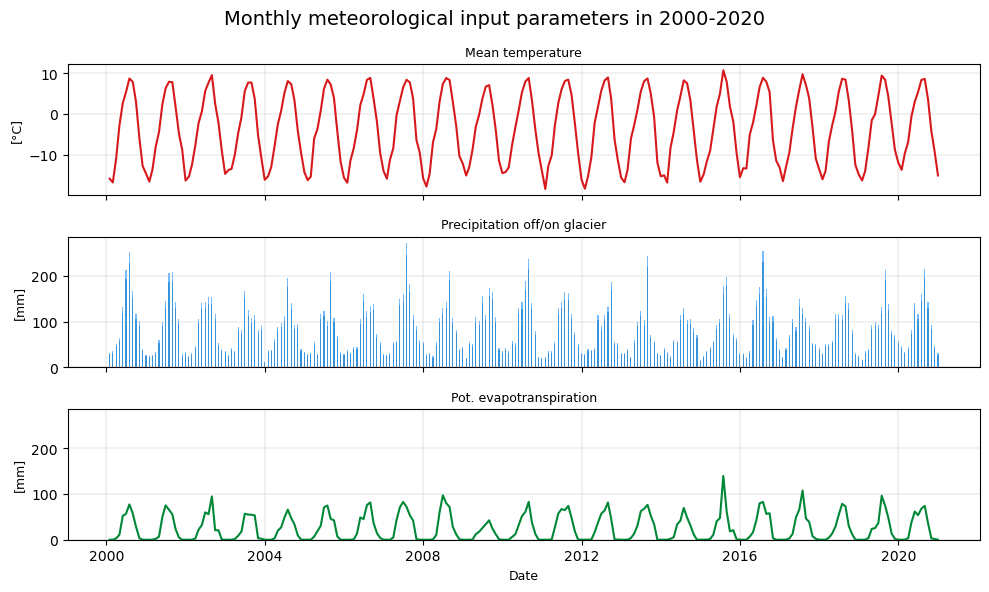

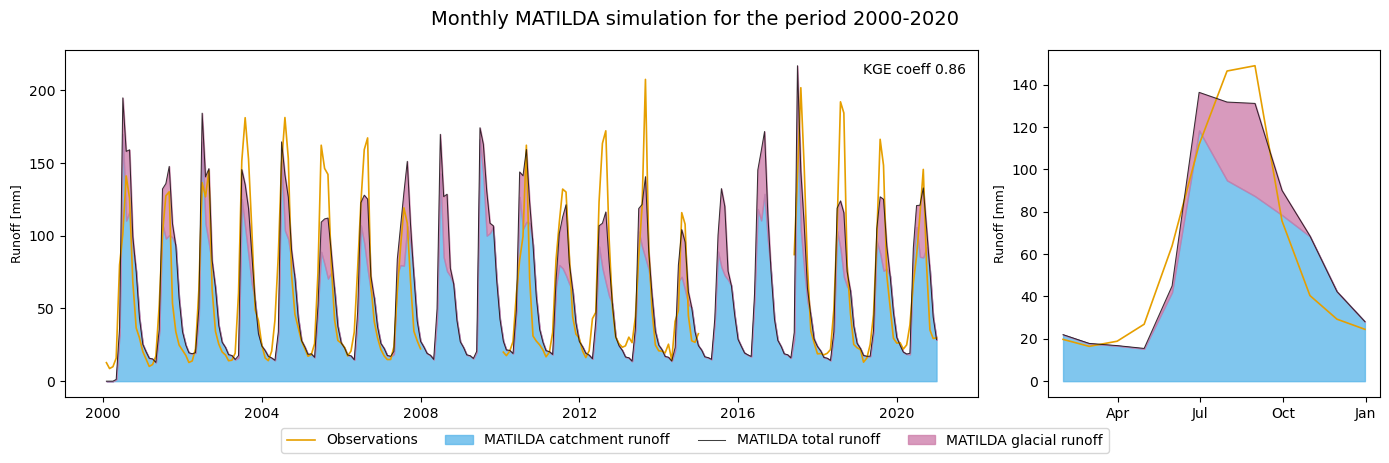

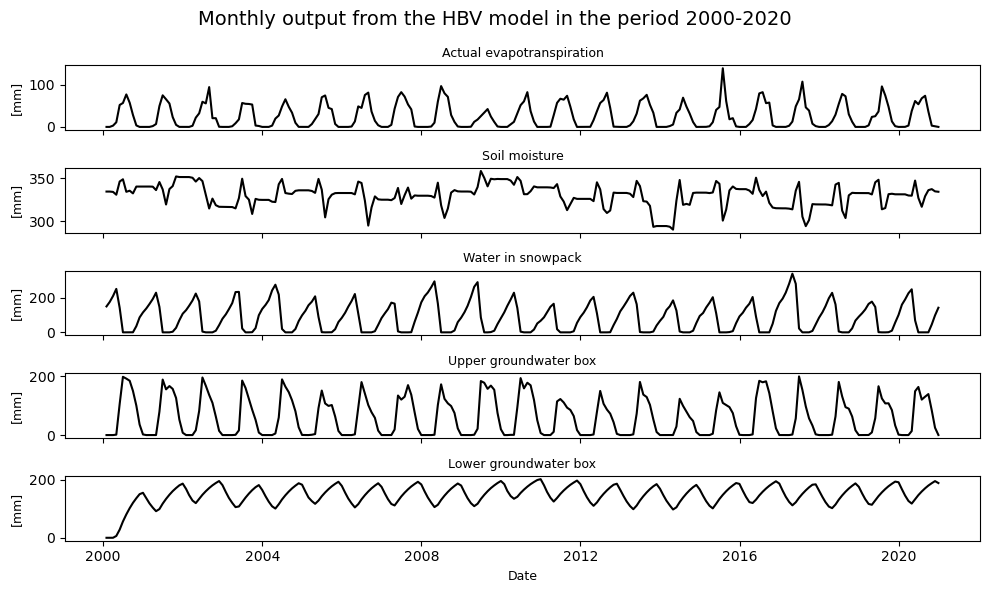

In [10]:
output_matilda = matilda_simulation(era5, obs, **settings, parameter_set=param)

In addition to the standard plots we can explore the results interactive `ploty` plots. Go ahead and zoom as you like or select/deselect individual curves.

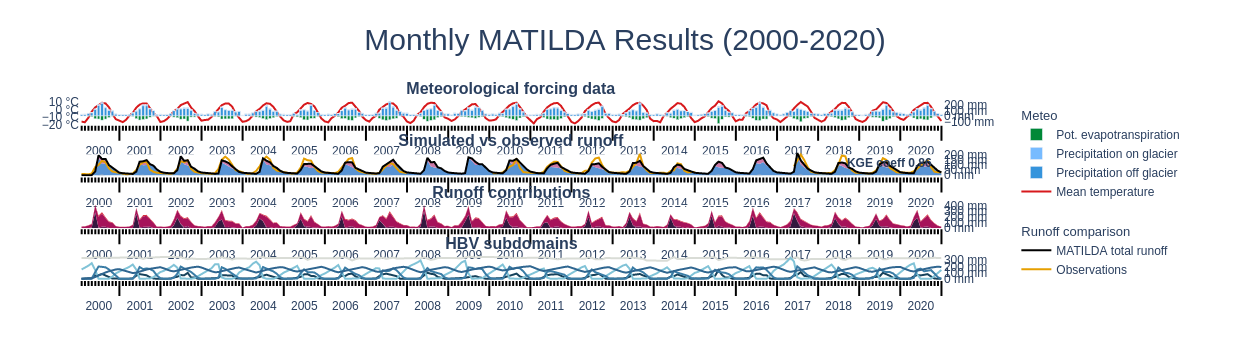

In [11]:
output_matilda[9].show()

The same works for the long-term seasonal cycle.

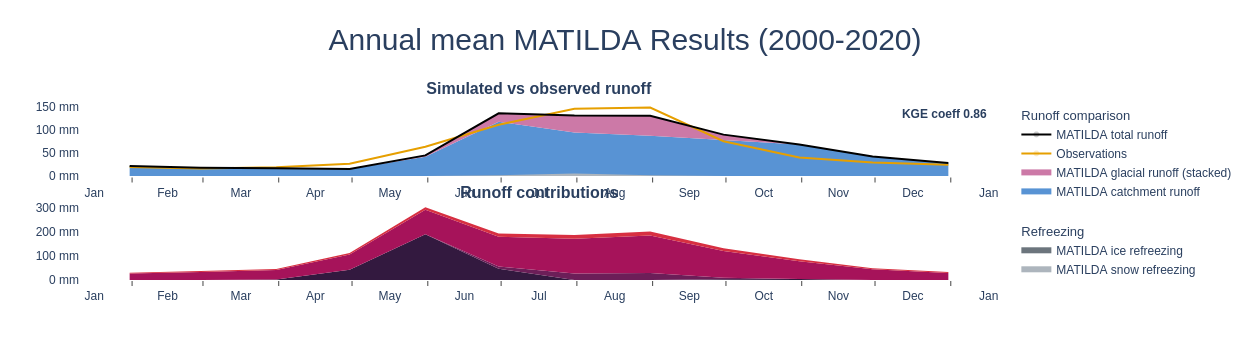

In [12]:
output_matilda[10].show()

## Reducing the parameter space - Sensitivity analysis with FAST

To reduce the computation time of the calibration procedure, we need to reduce the number of parameters to be optimized. Therefore, we will perform a global sensitivity analysis to identify the most important parameters and set the others to default values. The algorithm of choice will be the [Fourier Amplitude Sensitivity Test (FAST)](https://www.tandfonline.com/doi/abs/10.1080/00401706.1999.10485594) available through the [SPOTPY](https://github.com/thouska/spotpy/blob/master/src/spotpy/algorithms/fast.py) library. As before, we will show the general procedure with a few iterations, but display results from extensive runs on a HPC. You can use the results as a guide for your parameter choices, but keep in mind that they are highly correlated with your catchment properties, such as elevation range and glacier coverage.

First, we calculate the required number of iterations using a formula from [Henkel et. al. 2012](https://www.informs-sim.org/wsc12papers/includes/files/con308.pdf). We choose the SPOTPY default frequency step of 2 and set the interference factor to a maximum of 4, since we assume a high intercorrelation of the model parameters. The total number of parameters in MATILDA is 21.

In [13]:
def fast_iter(param, interf=4, freqst=2):
    """
    Calculates the number of parameter iterations needed for parameterization and sensitivity analysis using FAST.
    Parameters
    ----------
    param : int
        The number of input parameters being analyzed.
    interf : int
        The interference factor, which determines the degree of correlation between the input parameters.
    freqst : int
        The frequency step, which specifies the size of the intervals between each frequency at which the Fourier transform is calculated.
    Returns
    -------
    int
        The total number of parameter iterations needed for FAST.
    """
    return (1 + 4 * interf ** 2 * (1 + (param - 2) * freqst)) * param

print('Needed number of iterations for FAST: ' + str(fast_iter(21)))

Needed number of iterations for FAST: 52437


That is a lot of iterations! Running this routine on a single core would take about two days, but can be sped up significantly with each additional core. The setup would look exactly like the parameter optimization before.

**Note:** No matter what number of iterations you define, SPOTPY will run $N*k$ times, where $k$ is the number of model parameters. So even if we set `rep=10`, the algorithm will run at least 21 times.

In [14]:
from matilda.mspot_glacier import psample

fast_settings = {'rep': 52437,                              # Choose wisely before running
                 'target_mb': None,
                 'algorithm': 'fast',
                 'dbname': 'fast_matilda_example',
                 'dbname': dir_output + 'fast_example',
                 'dbformat': 'csv'
                      }
psample_settings.update(fast_settings)

print('Settings for FAST:\n\n')
for key in psample_settings.keys(): print(key + ': ' + str(psample_settings[key]))

# fast_results = psample(df=era5, obs=obs, **psample_settings)

Settings for FAST:


area_cat: 295.67484249904464
area_glac: 31.829413146585885
ele_cat: 3293.491688025922
ele_dat: 3335.668840874115
ele_glac: 4001.8798828125
elev_rescaling: True
freq: M
lat: 42.18280043250193
set_up_end: 1999-12-31
set_up_start: 1998-01-01
sim_end: 2020-12-31
sim_start: 2000-01-01
glacier_profile:      Elevation      Area          WE  EleZone  norm_elevation   delta_h
0       1970.0  0.000000      0.0000     1900        1.000000  1.003442
1       2000.0  0.000000      0.0000     2000        0.989324  0.945813
2       2100.0  0.000000      0.0000     2100        0.953737  0.774793
3       2200.0  0.000000      0.0000     2200        0.918149  0.632696
4       2300.0  0.000000      0.0000     2300        0.882562  0.515361
..         ...       ...         ...      ...             ...       ...
156     4730.0  0.000023  20721.3700     4700        0.017794 -0.000265
157     4740.0  0.000013  14450.2180     4700        0.014235 -0.000692
158     4750.0  0.000006  10551.4

We ran *FAST*s for the example catchment with the full number of iterations required. The results are saved in *CSV* files. We can use the `spotpy.analyser` library to create easy-to-read data frames from the databases. The summary shows the first (`S1`) and the total order sensitivity index (`ST`) for each parameter. `S1` refers to the variance of the model output explained by the parameter, holding all other parameters constant. The `ST` takes into account the interaction of the parameters and is therefore a good measure of the impact of individual parameters on the model output.

In [15]:
import spotpy
import os
import contextlib

def get_si(fast_results: str, to_csv: bool = False) -> pd.DataFrame:
    """
    Computes the sensitivity indices of a given FAST simulation results file.
    Parameters
    ----------
    fast_results : str
        The path of the FAST simulation results file.
    to_csv : bool, optional
        If True, the sensitivity indices are saved to a CSV file with the same
        name as fast_results, but with '_sensitivity_indices.csv' appended to
        the end (default is False).
    Returns
    -------
    pd.DataFrame
        A pandas DataFrame containing the sensitivity indices and parameter
        names.
    """
    if fast_results.endswith(".csv"):
        fast_results = fast_results[:-4]  # strip .csv
    results = spotpy.analyser.load_csv_results(fast_results)
    # Suppress prints
    with contextlib.redirect_stdout(open(os.devnull, 'w')):
        SI = spotpy.analyser.get_sensitivity_of_fast(results, print_to_console=False)
    parnames = spotpy.analyser.get_parameternames(results)
    sens = pd.DataFrame(SI)
    sens['param'] = parnames
    sens.set_index('param', inplace=True)
    if to_csv:
        sens.to_csv(os.path.basename(fast_results) + '_sensitivity_indices.csv', index=False)
    return sens

print(get_si(dir_input + 'FAST/' + 'example_fast_nolim.csv'))

                 S1        ST
param                        
lr_temp    0.001027  0.028119
lr_prec    0.000068  0.020323
BETA       0.000406  0.044880
CET        0.000183  0.061767
FC         0.000177  0.070427
K0         0.000128  0.056534
K1         0.000611  0.096560
K2         0.000564  0.073538
LP         0.000296  0.087176
MAXBAS     0.000166  0.045120
PERC       0.000079  0.051002
UZL        0.000129  0.056398
PCORR      0.011253  0.857075
TT_snow    0.000339  0.087251
TT_diff    0.000221  0.064408
CFMAX_ice  0.001746  0.121897
CFMAX_rel  0.000108  0.083392
SFCF       0.007414  0.137477
CWH        0.000612  0.063503
AG         0.000275  0.116503
RFS        0.000089  0.098914


If you have additional information on certain parameters, limiting their bounds can have a large impact on sensitivity. For our example catchment, field observations showed that the temperature lapse rate and precipitation correction were unlikely to exceed a certain range, so we limited the parameter space for both and ran a *FAST* again.

In [16]:
lim_dict = {'lr_temp_lo': -0.007, 'lr_temp_up': -0.005, 'PCORR_lo': 0.5, 'PCORR_up': 1.5}
# fast_results = psample(df=era5, obs=obs, **psample_settings, **lim_dict)

To see the effect of parameter restrictions on sensitivity, we can plot the indices of both runs. Feel free to explore further by adding more *FAST* outputs to the plot function.

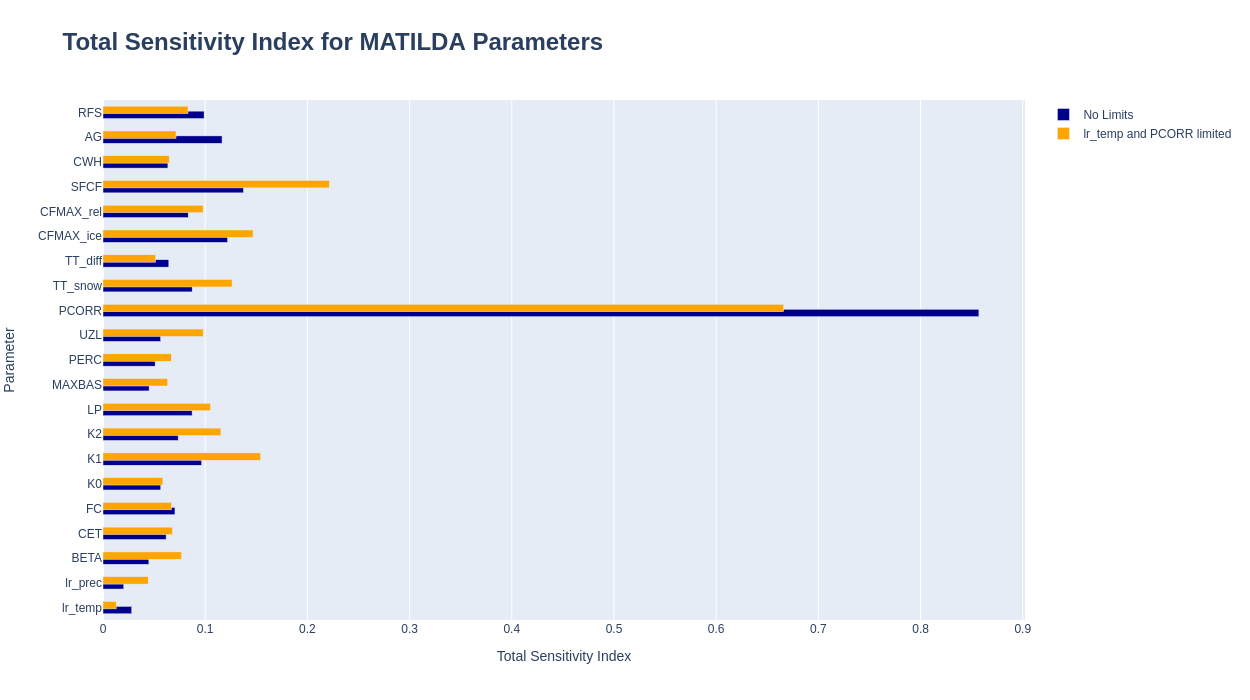

In [17]:
import plotly.graph_objs as go
import pandas as pd
import plotly.io as pio

def plot_sensitivity_bars(*dfs, labels=None, show=False, bar_width=0.3, bar_gap=0.6):
    """
    Plots a horizontal bar chart showing the total sensitivity index for each parameter in a MATILDA model.

    Parameters
    ----------
    *dfs : pandas.DataFrame
        Multiple dataframes containing the sensitivity indices for each parameter.
    labels : list of str, optional
        Labels to use for the different steps in the sensitivity analysis. If not provided, the default
        labels will be 'No Limits', 'Step 1', 'Step 2', etc.
    bar_width : float, optional
        Width of each bar in the chart.
    bar_gap : float, optional
        Space between bars.
    """
    traces = []
    colors = ['darkblue', 'orange', 'purple', 'cyan']   # add more colors if needed
    for i, df in enumerate(dfs):
        df = get_si(df)
        if i > 0:
            if labels is None:
                label = 'Step ' + str(i)
            else:
                label = labels[i]
        else:
            label = 'No Limits'
        trace = go.Bar(y=df.index,
                       x=df['ST'],
                       name=label,
                       orientation='h',
                       marker=dict(color=colors[i]),
                       width=bar_width)
        traces.append(trace)
    layout = go.Layout(title=dict(text='<b>' +'Total Sensitivity Index for MATILDA Parameters' + '<b>', font=dict(size=24)),
                   xaxis_title='Total Sensitivity Index',
                   yaxis_title='Parameter',
                   yaxis=dict(automargin=True),
                   bargap=bar_gap,
                   height=700)
    fig = go.Figure(data=traces, layout=layout)
    if show:
        fig.show()
        
step1 = dir_input + 'FAST/' + 'example_fast_nolim.csv'
step2 = dir_input + 'FAST/' + 'era5_ipynb_fast_step1.csv'

plot_sensitivity_bars(step1, step2, labels=['No Limits', 'lr_temp and PCORR limited'], show=True)

From this figure, we can easily identify the most important parameters. Depending on your desired accuracy and computational resources, you can choose a sensitivity threshold. Let's say we want to fix all parameters with a sensitivity index below 0.1. For our example, this will reduce the calibration parameters to 7.

In [18]:
si_df = get_si(step2)
sensitive = si_df.index[si_df['ST'] > 0.10].values

print('Parameters with a sensitivity index > 0.1:')
for i in sensitive: print(i)

Parameters with a sensitivity index > 0.1:
K1
K2
LP
PCORR
TT_snow
CFMAX_ice
SFCF


To give you an idea how much this procedure can reduce calibration time, we run the `fast_iter()` function again.

In [19]:
print('Needed number of iterations for FAST with all parameters: ' + str(fast_iter(21)))
print('Needed number of iterations for FAST with the 7 most sensitive parameters: ' + str(fast_iter(7)))

Needed number of iterations for FAST with all parameters: 52437
Needed number of iterations for FAST with the 7 most sensitive parameters: 4935


For a single core this would roughly translate into a reduction from 44h to 4h.

To run the calibration with the reduced parameter space, we simply need to define values for the fixed parameters and use a helper function to translate them into boundary arguments. Here we simply use the values from our last *SPOTPY* run (`param`).

In [20]:
from matilda.mspot_glacier import dict2bounds

fixed_param = {key: val for key, val in param.items() if key not in sensitive}
fixed_param_bounds = dict2bounds(fixed_param)
       
print('Fixed bounds:\n')
for key in fixed_param_bounds.keys(): print(key + ': ' + str(fixed_param_bounds[key]))

Fixed bounds:

lr_temp_lo: -0.006472598
lr_prec_lo: 0.00010296448
BETA_lo: 4.625306
CET_lo: 0.2875196
FC_lo: 364.81818
K0_lo: 0.28723368
MAXBAS_lo: 6.730105
PERC_lo: 1.1140852
UZL_lo: 198.82584
TT_diff_lo: 0.70977557
CFMAX_rel_lo: 1.2481626
CWH_lo: 0.0020890352
AG_lo: 0.8640329
RFS_lo: 0.21825151
lr_temp_up: -0.006472598
lr_prec_up: 0.00010296448
BETA_up: 4.625306
CET_up: 0.2875196
FC_up: 364.81818
K0_up: 0.28723368
MAXBAS_up: 6.730105
PERC_up: 1.1140852
UZL_up: 198.82584
TT_diff_up: 0.70977557
CFMAX_rel_up: 1.2481626
CWH_up: 0.0020890352
AG_up: 0.8640329
RFS_up: 0.21825151


The `psample()` setup is then as simple as before.

In [21]:
new_settings = {'rep': 10,                             # Number of model runs. For advice check the documentation of the algorithms.
                'glacier_only': False,                 # True when calibrating a entirely glacierized catchment
                'obj_dir': 'maximize',                 # should your objective funtion be maximized (e.g. NSE) or minimized (e.g. RMSE)
                'target_mb': -156,                     # Average annual glacier mass balance to target at
                'dbformat': None,                      # Write the results to a file ('csv', 'hdf5', 'ram', 'sql')
                'output': None,                        # Choose where to store the files
                'algorithm': 'lhs',                    # Choose algorithm (for parallelization: mc, lhs, fast, rope, sceua or demcz)
                'dbname': 'era5_matilda_example',      # Choose name
                       
                'parallel': False,                     # Distribute the calculation on multiple cores or not
                # 'cores': 20                           # Set number of cores when running parallel
                      }
psample_settings.update(new_settings)

best_summary = psample(df=era5, obs=obs, **psample_settings, **fixed_param_bounds)

Initializing the  Latin Hypercube Sampling (LHS)  with  10  repetitions
The objective function will be maximized
Starting the LHS algotrithm with 10 repetitions...
Creating LatinHyperCube Matrix
1 of 10, maximal objective function=-0.529037, time remaining: 00:00:11
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
2 of 10, maximal objective function=-0.291139, time remaining: 00:00:13
3 of 10, maximal objective function=-0.120822, time remaining: 00:00:13
4 of 10, maximal objective function=-0.120822, time remaining: 00:00:11
5 of 10, maximal objective function=-0.120822, time remaining: 00:00:10
6 of 10, maximal objective function=0.285465, time remaining: 00:00:07
7 of 10, maximal objective function=0.391547, time remaining: 00:00:05
8 of 10, maximal objective function=0.391547, time remaining: 00:00:03
9 of 10, maximal objective function=0.391547, time remaining: 00:00:00
10 of 10, maximal objective function=0.391547, time remaining: 23:59:57

*** Final SPOTP

**Note:** The number of iterations required depends on the selected algorithm and the number of free parameters. To choose the correct setting, consult the [SPOTPY documentation](https://spotpy.readthedocs.io/en/latest/Algorithm_guide/) and the original literature for each algorithm.

Now, we save the best parameter set for use in the next notebook. The set is stored in the `best_summary` variable.

**Note:** In our example we will skip this step and use the [result from the calibration on an HPC cluster](#param). 

In [22]:
# param = best_summary['best_param']

Finally, we store the parameter set in a `.yml` file.

In [23]:
write_yaml(param, dir_output + 'parameters.yml')
print(f"Parameter set stored in '{dir_output}parameters.yml'")

Parameter set stored in 'output/parameters.yml'
